In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    return x

def make_label(x, w):
    window=w
    x['label_all']=x['label']
    for i in range(1, window):
        x.loc[(x['label_all']==1)|(x['label'].shift(i)==1), 'label_all']=1
        x.loc[(x['label_all']==0)&(x['label'].shift(i)==0), 'label_all']=0
    
    x['label']=x['label_all']
    return x[['label']]

def calc_leq(df, unit):
    df.reset_index(inplace=True, drop=True)
    for i in range(int(len(df)/unit)+1):
        hour_df=df.loc[i*unit:(i+1)*unit, 'original'].copy()
        N=len(hour_df)
        Leq=10*np.log10(np.sum(np.power(10, hour_df/10)))-10*np.log10(N)
        df.loc[i*unit:(i+1)*unit, 'leq']=Leq
    return df

def leq_filter(df):
    df=calc_leq(df, 18000)
    df.loc[(df['original']<df['leq']), 'd']=0
    return df

def validate(test_v, anorm, thr):
    test_v['z']=np.where(anorm>=thr, 1, 0)
    test_v.reset_index(inplace=True, drop=True)

    #     適合率
    tp=test_v[(test_v['label']==1)&(test_v['z']==1)]
    z_p=test_v[test_v['z']==1]
    pre_score=len(tp)/len(z_p)

    #     再現率
    df_anorm=[]
    search= 1 if test_v.loc[0, 'label']==0 else 0
    for num in range(len(test_v)):
        if search==1 and test_v.loc[num, 'label']==search:
            start=num
            search=0
        elif search==0 and test_v.loc[num, 'label']==search:
            stop=num-1
            anorm_range=test_v.loc[start:stop].copy()
            df_anorm.append(anorm_range)
            search=1
            
    count=[]
    for i in range(len(df_anorm)):
        if len(df_anorm[i].loc[df_anorm[i]['z']==1])>=1:
               count.append(i)    

    re_score=len(count)/len(df_anorm)

    return pre_score, re_score

def figure(df_test, anorm, d, thr):
    df_test['z']=np.where(d>=thr, 1, 0)
    
    z=df_test['z'].values*100
    test_plot=df_test['original'].values
    num_ax=math.ceil(len(test_plot)/17999)
    label=df_test['label'].values*100
    label_index=range(len(label))
    time_unit=60
    time=[t*0.2/60 for t in range(len(anorm))]
    plt.rcParams["font.size"] = 30

    fig, ax=plt.subplots(num_ax, 1, figsize=(35, 15*num_ax))
    for i in range(num_ax):
        ax[i].plot(time, anorm, '-r',linewidth = 1 )
        ax[i].plot(time, test_plot, '-k',linewidth = 2)
        ax[i].fill_between(time, label, facecolor='lime' )
        ax[i].fill_between(time, z, facecolor='coral' )
        ax[i].set_ylim(0, 90)
        ax[i].set_xlim(i*time_unit, time_unit*(i+1))
        ax[i].set_xticks(np.arange(60*i, 60*(i+1)))
        ax[i].xaxis.set_tick_params(rotation=70)
    plt.show()

def fig_pr(test_v, d, bins):
    bins_1=int(bins*0.8)
    thr_1=np.linspace(d.min(), 0.6, bins_1)
    thr_2=np.linspace(0.61, d.max(), bins-bins_1)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)
    f_score=(2*precision*recall)/(precision+recall)
    thr=thresholds[np.argmax(f_score)]

    plt.rcParams["font.size"] = 10
    plt.plot(recall, precision, marker='o', markevery=[np.argmax(f_score)], label='PR curve (AUC = %.2f)'%auc)
    plt.legend()
    plt.title('PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

    return precision, recall, f_score, thresholds, thr, auc

def fig_th_f(thresholds, f_score):
    plt.plot(thresholds, f_score, marker="o", markevery=[np.argmax(f_score)])
    plt.xlabel('thresholds')
    plt.ylabel('f_score')
    plt.grid(True)
    plt.show()
    
    return thresholds[np.argmax(f_score)], f_score.max()

In [3]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

,original,label,time,day
0,53.4,0,15,0
1,52.8,0,15,0
2,52.8,0,15,0
3,53.2,0,15,0
4,53.6,0,15,0
...,...,...,...,...
3995345,45.9,0,5,9
3995346,45.6,0,5,9
3995347,45.8,0,5,9
3995348,45.7,0,5,9


### チューニング結果(ホールドアウト法)
* best_params={'window': 5, 'nk': 12}

In [4]:
df_list=[]
best_params={'window': 5, 'nk': 12}
window=best_params['window']
for i in set(df['day']):
    lag=[] 
    lag.append(make_data(df.loc[df['day']==i, ['original']], 'original', window))
    lag.append(df.loc[df['day']==i, ['day']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
df=pd.concat(df_list)
df=df.dropna().reset_index(drop=True)
df

,original,original_lag1,original_lag2,original_lag3,original_lag4,day
0,53.6,53.2,52.8,52.8,53.4,0
1,54.0,53.6,53.2,52.8,52.8,0
2,54.7,54.0,53.6,53.2,52.8,0
3,55.7,54.7,54.0,53.6,53.2,0
4,55.5,55.7,54.7,54.0,53.6,0
...,...,...,...,...,...,...
3995305,45.9,45.6,45.4,45.9,46.0,9
3995306,45.6,45.9,45.6,45.4,45.9,9
3995307,45.8,45.6,45.9,45.6,45.4,9
3995308,45.7,45.8,45.6,45.9,45.6,9


## クロスバリデーション
### モデルの性能を総合的に評価

In [5]:
cv_data_list=df['day'].unique().tolist()
#チューニングに使用した検証データ
valid=[0]

for i in range(len(valid)):
    #テストデータ＋訓練データ＝クロスバリデーションに使用するデータ
    #検証データを除く
    cv_data_list.remove(valid[i])
cv_data_list

[1, 2, 3, 4, 5, 6, 7, 8, 9]

訓練データ：[2, 3, 4, 5, 6, 7, 8, 9]
テストデータ：[1]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


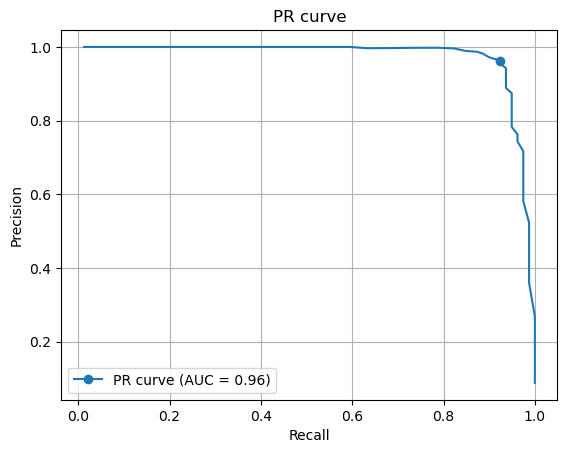

AUC：0.962124538058557
F値（最高）：0.942847150490846
適合率（最高）：0.9624242424242424
再現率（最高）：0.9240506329113924
----------------閾値の妥当性評価（F値）------------------
閾値2.1959719026445352
F値：0.8542070503473712
適合率：0.9976359338061466
再現率：0.7468354430379747

訓練データ：[1, 3, 4, 5, 6, 7, 8, 9]
テストデータ：[2]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


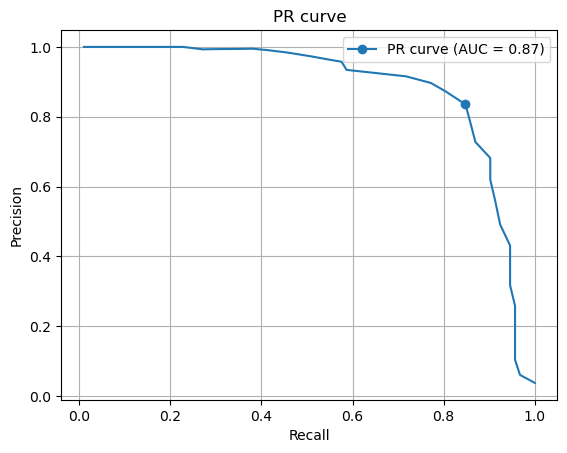

AUC：0.8741391577081457
F値（最高）：0.8415134478042852
適合率（最高）：0.8352941176470589
再現率（最高）：0.8478260869565217
----------------閾値の妥当性評価（F値）------------------
閾値1.5221045795611674
F値：0.8295836968714945
適合率：0.8023809523809524
再現率：0.8586956521739131

訓練データ：[1, 2, 4, 5, 6, 7, 8, 9]
テストデータ：[3]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


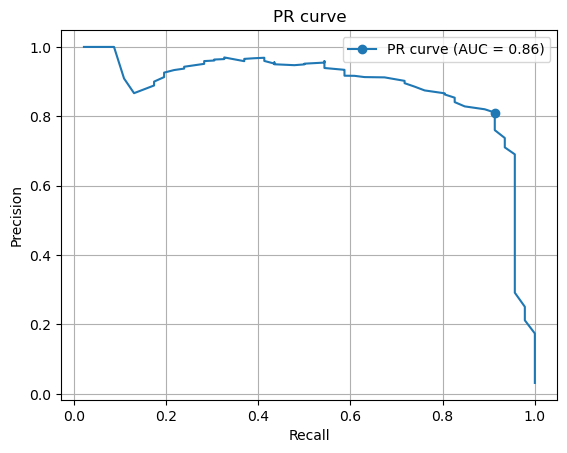

AUC：0.8627360001461003
F値（最高）：0.8588630939466262
適合率（最高）：0.810752688172043
再現率（最高）：0.9130434782608695
----------------閾値の妥当性評価（F値）------------------
閾値2.2240342013454497
F値：0.716458481651673
適合率：0.9192825112107623
再現率：0.5869565217391305

訓練データ：[1, 2, 3, 5, 6, 7, 8, 9]
テストデータ：[4]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


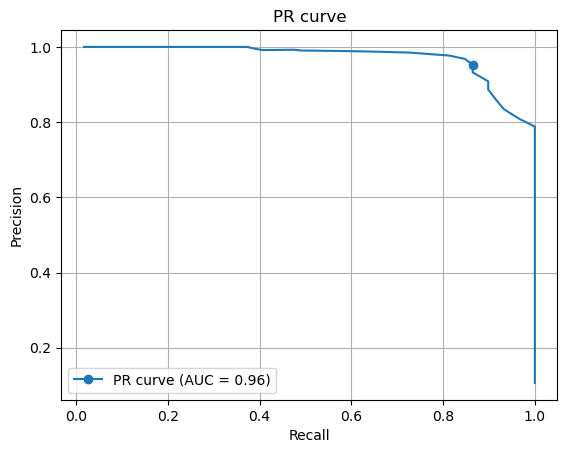

AUC：0.9558630380087108
F値（最高）：0.9065174456879526
適合率（最高）：0.9529411764705882
再現率（最高）：0.864406779661017
----------------閾値の妥当性評価（F値）------------------
閾値2.2117404619398418
F値：0.9065174456879526
適合率：0.9529411764705882
再現率：0.864406779661017

訓練データ：[1, 2, 3, 4, 6, 7, 8, 9]
テストデータ：[5]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


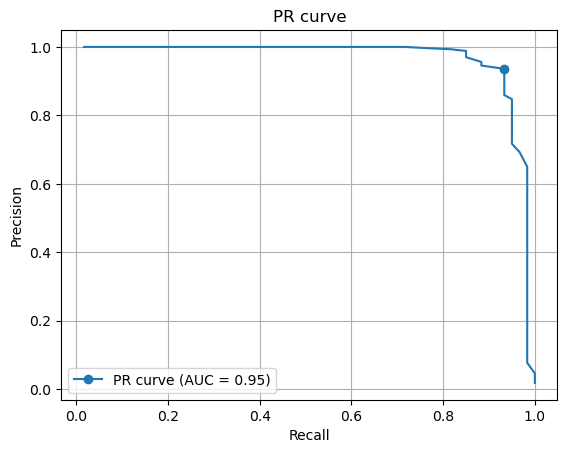

AUC：0.9499948516831933
F値（最高）：0.9346282543050681
適合率（最高）：0.9359267734553776
再現率（最高）：0.9333333333333333
----------------閾値の妥当性評価（F値）------------------
閾値1.9311107225713622
F値：0.9133430373605046
適合率：0.9653333333333334
再現率：0.8666666666666667

訓練データ：[1, 2, 3, 4, 5, 7, 8, 9]
テストデータ：[6]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


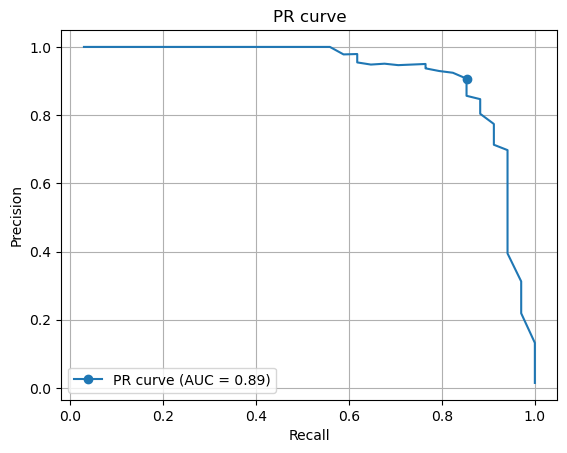

AUC：0.8930726748822917
F値（最高）：0.8791294209094441
適合率（最高）：0.9069767441860465
再現率（最高）：0.8529411764705882
----------------閾値の妥当性評価（F値）------------------
閾値1.7603819821840818
F値：0.8565253932044663
適合率：0.8601398601398601
再現率：0.8529411764705882

訓練データ：[1, 2, 3, 4, 5, 6, 8, 9]
テストデータ：[7]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


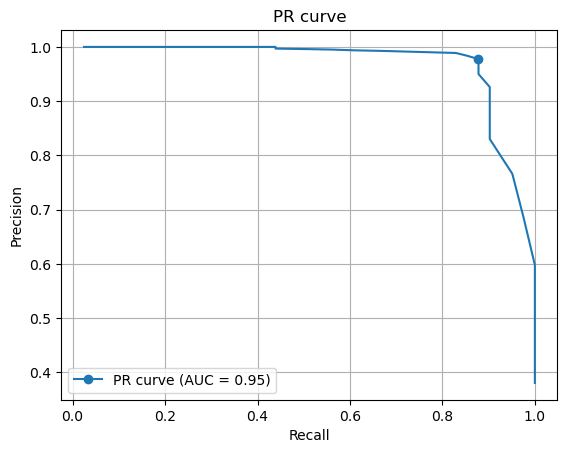

AUC：0.9453730626733851
F値（最高）：0.9251097995293407
適合率（最高）：0.977501196744854
再現率（最高）：0.8780487804878049
----------------閾値の妥当性評価（F値）------------------
閾値1.5437800035227425
F値：0.7918597304128056
適合率：0.9928698752228164
再現率：0.6585365853658537

訓練データ：[1, 2, 3, 4, 5, 6, 7, 9]
テストデータ：[8]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


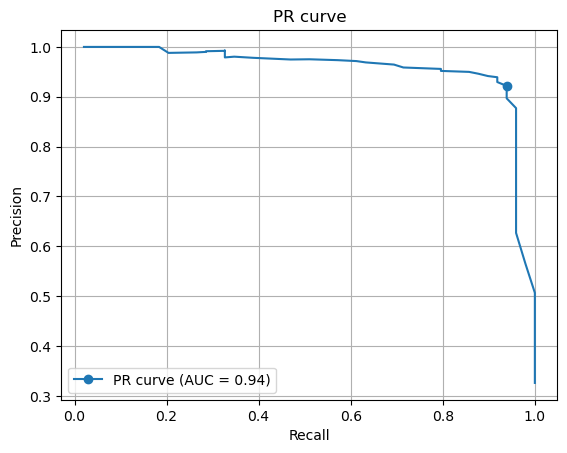

AUC：0.9364428549903094
F値（最高）：0.930179320869897
適合率（最高）：0.9217391304347826
再現率（最高）：0.9387755102040817
----------------閾値の妥当性評価（F値）------------------
閾値1.4013261407004047
F値：0.855973974763407
適合率：0.955067920585162
再現率：0.7755102040816326

訓練データ：[1, 2, 3, 4, 5, 6, 7, 8]
テストデータ：[9]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


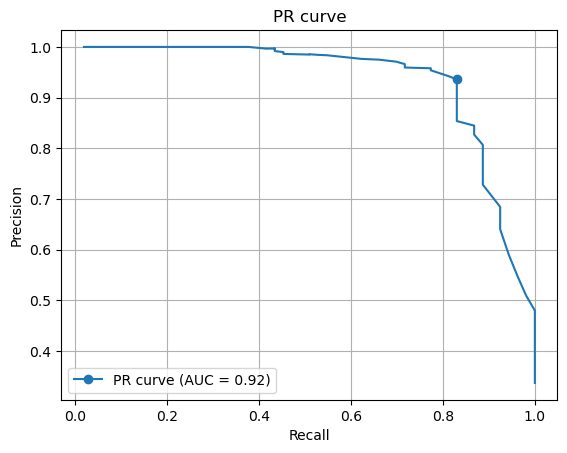

AUC：0.9158397559314425
F値（最高）：0.8798450689869255
適合率（最高）：0.9358196010407632
再現率（最高）：0.8301886792452831
----------------閾値の妥当性評価（F値）------------------
閾値1.3423350967885586
F値：0.8322853549788499
適合率：0.9578107183580388
再現率：0.7358490566037735

----------------総合評価------------------
・異常検知モデルの性能
	AUC平均：0.9217317704535706
	AUC標準偏差：0.03491619309555292
・閾値の妥当性
	適合率平均：0.9337180312786288
	適合率標準偏差：0.0604256482389114

	再現率平均：0.7718220095333944
	再現率標準偏差：0.09465470476626124

	f値平均：0.8396393516976137
	f値標準偏差：0.05605622703600965



In [6]:
test_list=[]
auc_list=[]
p_list=[]
r_list=[]
f_list=[]
#テストデータを何日ずつにするか
test_daynum=1
cv_comb=np.array(cv_data_list).reshape((-1, test_daynum)).tolist()
for i in cv_comb:
    train_day=[k for k in cv_data_list if k not in i]
    test_day=i
    print(f'訓練データ：{train_day}')
    print(f'テストデータ：{test_day}日目')

    train=df[(df['day'].isin(train_day))][df.columns[:-1]].reset_index(drop=True)
    test=df[(df['day'].isin(test_day))][df.columns[:-1]].reset_index(drop=True)

    nk = best_params['nk']
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]
    d = np.mean(d, axis=1)
    
    test_v=original[original['day'].isin(test_day)][['original', 'label', 'day']].reset_index(drop=True)
    test_v['d']=d[0]
    
    if len(test_day)==1:
        test_v.loc[window-1:, 'd']=d
    else:
        for day in test_day:
            tmp=test_v.loc[test_v['day']==day,  'd']
            tmp[window-1:]=df.loc[(df['day']==day), 'd'].values
            test_v.loc[test_v['day']==day,  'd']=tmp
        
    #道路交通騒音に埋もれている異常音は正常とする
    test_v=leq_filter(test_v)
    #AUCを計算するために0～1にスケーリング
    test_v['d']=test_v['d']/test_v['d'].max()
    d_test=test_v['d'].values
    
    print('------------異常検知モデルの性能評価（PR曲線AUC）-------------')
    thr_bins=100
    p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
    print('\033[31m'+f'AUC：{auc}'+'\033[0m')
    print(f'F値（最高）：{f_score.max()}')
    print(f'適合率（最高）：{p_score[np.argmax(f_score)]}')
    print(f'再現率（最高）：{r_score[np.argmax(f_score)]}')
    auc_list.append(auc)
    
    
    print('----------------閾値の妥当性評価（F値）------------------')
    test_v=original[original['day'].isin(test_day)][['original', 'label', 'day']].reset_index(drop=True)
    test_v['d']=d[0]
    
    if len(test_day)==1:
        test_v.loc[window-1:, 'd']=d
    else:
        for day in test_day:
            tmp=test_v.loc[test_v['day']==day,  'd']
            tmp[window-1:]=df.loc[(df['day']==day), 'd'].values
            test_v.loc[test_v['day']==day,  'd']=tmp
        
    #道路交通騒音に埋もれている異常音は正常とする
    test_v=leq_filter(test_v)
    nonscaled_d=test_v['d'].values
    
    #kmeans
    n_clusters=2
    model = KMeans(n_clusters=n_clusters)  
    model.fit(d.reshape((-1, 1)))
    clusters = model.predict(d.reshape((-1, 1)))  
    result=pd.DataFrame({'d':d, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].max())
    thr_min=sorted(thr_list)[-2]
    thr_max=sorted(thr_list)[-1]
    thr_range=result.loc[(result['d']>thr_min)&(result['d']<=thr_max), ['d']]
    Q1 = thr_range.quantile(0.25)
    Q3 = thr_range.quantile(0.75)
    IQR = Q3 - Q1
    thr = min(float(Q3 + 1.5 * IQR), thr_max)
    print(f'閾値{thr}')
    
    precision, recall=validate(test_v, nonscaled_d, thr)
    f_score=(2*precision*recall)/(precision+recall)
    print('\033[31m'+f'F値：{f_score}'+'\033[0m')
    print(f'適合率：{precision}')
    print(f'再現率：{recall}')
    p_list.append(precision)
    r_list.append(recall)
    f_list.append(f_score)
    
    test_list.append(test_v)
    print('=====================================================================================\n')

print('----------------総合評価------------------')
#平均
auc_mean=np.mean(auc_list)
p_mean=np.mean(p_list)
r_mean=np.mean(r_list)
f_mean=np.mean(f_list)

#標準偏差
auc_std=np.std(auc_list)
p_std=np.std(p_list)
r_std=np.std(r_list)
f_std=np.std(f_list)


print('・異常検知モデルの性能')
print(f'\tAUC平均：{auc_mean}')
print(f'\tAUC標準偏差：{auc_std}')

print('・閾値の妥当性')
print(f'\t適合率平均：{p_mean}')
print(f'\t適合率標準偏差：{p_std}')
print('')
print(f'\t再現率平均：{r_mean}')
print(f'\t再現率標準偏差：{r_std}')
print('')
print(f'\tf値平均：{f_mean}')
print(f'\tf値標準偏差：{f_std}')
print('')
result_test=pd.concat(test_list).reset_index(drop=True)

(0.0, 100.0)

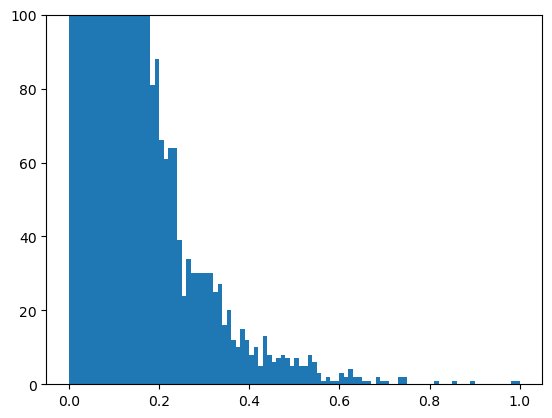

In [17]:
plt.hist(d_test, bins=100)
plt.ylim(0, 100)